In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0

import random
import numpy as np
import torch

try:
    import nltk
    import sklearn
except ModuleNotFoundError: # Install nltk and sklearn if necessary
    !pip install --quiet nltk, sklearn
    import nltk

def seed_all(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

seed_all()

<ipython-input-1-f209b71e5400>:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


### **Data**

We use text as an example and design:

1.   A classifier
2.   an ordinal regressor
3.   a sequence labeller


In [2]:
nltk.download('treebank')
nltk.download('brown')
nltk.download('punkt')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

### **Sentiment**

In [3]:
from nltk.corpus import treebank, brown

viewing the generes in brown corpus

In [4]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

In [5]:
print("'fiction' examples")
for i, x in zip(range(3), brown.sents(categories=['fiction'])):
    print(i, x)
print()
print("'religion' examples")
for i, x in zip(range(3), brown.sents(categories=['religion'])):
    print(i, x)
print()
print("'learned' examples")
for i, x in zip(range(3), brown.sents(categories=['learned'])):
    print(i, x)

'fiction' examples
0 ['Thirty-three']
1 ['Scotty', 'did', 'not', 'go', 'back', 'to', 'school', '.']
2 ['His', 'parents', 'talked', 'seriously', 'and', 'lengthily', 'to', 'their', 'own', 'doctor', 'and', 'to', 'a', 'specialist', 'at', 'the', 'University', 'Hospital', '--', 'Mr.', 'McKinley', 'was', 'entitled', 'to', 'a', 'discount', 'for', 'members', 'of', 'his', 'family', '--', 'and', 'it', 'was', 'decided', 'it', 'would', 'be', 'best', 'for', 'him', 'to', 'take', 'the', 'remainder', 'of', 'the', 'term', 'off', ',', 'spend', 'a', 'lot', 'of', 'time', 'in', 'bed', 'and', ',', 'for', 'the', 'rest', ',', 'do', 'pretty', 'much', 'as', 'he', 'chose', '--', 'provided', ',', 'of', 'course', ',', 'he', 'chose', 'to', 'do', 'nothing', 'too', 'exciting', 'or', 'too', 'debilitating', '.']

'religion' examples
0 ['As', 'a', 'result', ',', 'although', 'we', 'still', 'make', 'use', 'of', 'this', 'distinction', ',', 'there', 'is', 'much', 'confusion', 'as', 'to', 'the', 'meaning', 'of', 'the', 'basic

In [6]:
def split_nltk_categorised_corpus(corpus, categories, max_length=30, num_heldout=100):
    """
    Shuffle and split a corpus.
    corpus: a corpus of tagged sequences, each sequence is a pair, each pair is a token and a tag.
    max_length: discard sentences longer than this

    Return:
        (training word sequences, training tag sequences),
        (dev word sequences, dev tag sequences),
        (test word sequences, test tag sequences),
    """

    sentences = []
    labels = []
    for k, c in enumerate(categories):
        seqs = corpus.sents(categories=[c])
        sentences.extend(seqs)
        labels.extend(len(seqs) * [k])
    # do not change the seed in here
    order = np.random.RandomState(42).permutation(np.arange(len(sentences)))
    shuffled_sentences = [[w for w in sentences[i]] for i in order if len(sentences[i]) <= max_length]
    shuffled_labels = [labels[i] for i in order if len(sentences[i]) <= max_length]
    return (shuffled_sentences[2*num_heldout:], shuffled_labels[2*num_heldout:]), (shuffled_sentences[num_heldout:2*num_heldout], shuffled_labels[num_heldout:2*num_heldout]), (shuffled_sentences[:num_heldout], shuffled_labels[:num_heldout])

In [7]:
%%time
(cat_training_x, cat_training_y), (cat_dev_x, cat_dev_y), (cat_test_x, cat_test_y) = split_nltk_categorised_corpus(brown, brown.categories(), num_heldout=1000)
print(f"Number of sentences: training={len(cat_training_x)} dev={len(cat_dev_x)} test={len(cat_test_x)}")

Number of sentences: training=44685 dev=1000 test=1000
CPU times: user 6.08 s, sys: 249 ms, total: 6.33 s
Wall time: 8.88 s


In [8]:
len(cat_training_x), len(cat_dev_x), len(cat_test_x)

(44685, 1000, 1000)

In [9]:
cat_training_y[0], cat_training_x[0]

(1,
 ['That',
  'is',
  'why',
  'the',
  'members',
  'of',
  'the',
  'beat',
  'generation',
  'proudly',
  'assume',
  'the',
  'title',
  'of',
  'the',
  'holy',
  'barbarians',
  ';',
  ';'])

### **Age**

In [10]:
# Download the data
!wget https://surfdrive.surf.nl/files/index.php/s/2xWdFxnewjN9gsq/download -O blog-authorship.json.gz
!gzip -d blog-authorship.json.gz

--2023-05-14 06:08:05--  https://surfdrive.surf.nl/files/index.php/s/2xWdFxnewjN9gsq/download
Resolving surfdrive.surf.nl (surfdrive.surf.nl)... 145.107.8.140, 145.107.56.140, 2001:610:10b:2:0:a11:da7a:5afe, ...
Connecting to surfdrive.surf.nl (surfdrive.surf.nl)|145.107.8.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25699440 (25M) [application/gzip]
Saving to: ‘blog-authorship.json.gz’

blog-authorship.jso 100%[===================>]  24.51M  8.05MB/s    in 3.0s    

2023-05-14 06:08:09 (8.05 MB/s) - ‘blog-authorship.json.gz’ saved [25699440/25699440]



In [11]:
import json

with open("blog-authorship.json") as f:
    blog_data = json.load(f)

In [12]:
blog_data.keys()

dict_keys(['source', 'ack', 'subset', 'format', 'training', 'dev', 'test'])

In [13]:
blog_data['source'], blog_data['ack']

('[Blog authorship corpus](https://www.kaggle.com/rtatman/blog-authorship-corpus)',
 '[Schler et al (2006)](http://www.cs.biu.ac.il/~schlerj/schler_springsymp06.pdf)')

In [14]:
len(blog_data['training']), len(blog_data['dev']), len(blog_data['test'])

(200000, 40000, 49174)

In [15]:
blog_data['training'][0]

['I hate exams considering I just failed one. Yippee', 16]

In [16]:
%%time
from nltk.tokenize import word_tokenize

# Tokenize and shuffle the data.
order = np.random.RandomState(42).permutation(np.arange(len(blog_data["training"])))
blog_training_x = [word_tokenize(blog_data["training"][i][0].lower()) for i in order]
blog_training_y = [[blog_data["training"][i][1]] for i in order]
blog_dev_x = [word_tokenize(x[0].lower()) for x in blog_data["dev"]]
blog_dev_y = [[x[1]] for x in blog_data["dev"]]
blog_test_x = [word_tokenize(x[0].lower()) for x in blog_data["test"]]
blog_test_y = [[x[1]] for x in blog_data["test"]]

CPU times: user 1min 38s, sys: 737 ms, total: 1min 39s
Wall time: 1min 39s


In [17]:
# Example pre-processed data point
print(f"input: {blog_training_x[0]}")
print(f"age of author: {blog_training_y[0]}")

input: ['urllink', 'this', 'is', 'my', 'friend', 'sam', '.', 'he', "'s", 'a', 'little', 'weird', '.', 'he', "'s", 'nice', 'though', '.', 'but', 'weird', '.']
age of author: [17]


In [18]:
example = treebank.tagged_sents(tagset='universal')[0]  # 'universal' here refers to the style of tags
example

[('Pierre', 'NOUN'),
 ('Vinken', 'NOUN'),
 (',', '.'),
 ('61', 'NUM'),
 ('years', 'NOUN'),
 ('old', 'ADJ'),
 (',', '.'),
 ('will', 'VERB'),
 ('join', 'VERB'),
 ('the', 'DET'),
 ('board', 'NOUN'),
 ('as', 'ADP'),
 ('a', 'DET'),
 ('nonexecutive', 'ADJ'),
 ('director', 'NOUN'),
 ('Nov.', 'NOUN'),
 ('29', 'NUM'),
 ('.', '.')]

In [19]:
def split_nltk_tagged_corpus(corpus, max_length=30, num_heldout=100):
    """
    Shuffle and split a corpus.
    corpus: a corpus of tagged sequences, each sequence is a pair, each pair is a token and a tag.
    max_length: discard sentences longer than this

    Return:
        (training word sequences, training tag sequences),
        (dev word sequences, dev tag sequences),
        (test word sequences, test tag sequences),
    """
    tagged_sentences = corpus.tagged_sents(tagset='universal')
    # do not change the seed in here
    order = np.random.RandomState(42).permutation(np.arange(len(tagged_sentences)))
    word_sequences = [[w.lower() for w, t in tagged_sentences[i]] for i in order if len(tagged_sentences[i]) <= max_length]
    tag_sequences = [[t for w, t in tagged_sentences[i]] for i in order if len(tagged_sentences[i]) <= max_length]
    return (word_sequences[2*num_heldout:], tag_sequences[2*num_heldout:]), (word_sequences[num_heldout:2*num_heldout], tag_sequences[num_heldout:2*num_heldout]), (word_sequences[:num_heldout], tag_sequences[:num_heldout])

In [20]:
%%time
(tagger_training_x, tagger_training_y), (tagger_dev_x, tagger_dev_y), (tagger_test_x, tagger_test_y) = split_nltk_tagged_corpus(treebank, num_heldout=100)
print(f"Number of sentences: training={len(tagger_training_x)} dev={len(tagger_dev_x)} test={len(tagger_test_x)}")

Number of sentences: training=2486 dev=100 test=100
CPU times: user 2.76 s, sys: 202 ms, total: 2.96 s
Wall time: 2.97 s


In [21]:
print("# A few training sentences\n")
for n in range(3):
    print(f"x_{n} = {tagger_training_x[n]}")
    print(f"y_{n} = {tagger_training_y[n]}")
    print()

# A few training sentences

x_0 = ['they', 'know', '0', 'he', 'is', 'generally', 'opposed', 'to', 'cop-killer', 'bullets', ',', 'but', 'that', 'he', 'had', 'some', 'reservations', 'about', 'the', 'language', 'in', 'the', 'legislation', '.', "''"]
y_0 = ['PRON', 'VERB', 'X', 'PRON', 'VERB', 'ADV', 'VERB', 'PRT', 'ADJ', 'NOUN', '.', 'CONJ', 'ADP', 'PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', '.', '.']

x_1 = ['california', "'s", 'education', 'department', 'suspects', 'adult', 'responsibility', 'for', 'erasures', 'at', '40', 'schools', 'that', '*t*-85', 'changed', 'wrong', 'answers', 'to', 'right', 'ones', 'on', 'a', 'statewide', 'test', '.']
y_1 = ['NOUN', 'PRT', 'NOUN', 'NOUN', 'VERB', 'NOUN', 'NOUN', 'ADP', 'NOUN', 'ADP', 'NUM', 'NOUN', 'DET', 'X', 'VERB', 'ADJ', 'NOUN', 'PRT', 'ADJ', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', '.']

x_2 = ['the', 'loan', 'may', 'be', 'extended', '*-1', 'by', 'the', 'mcalpine', 'group', 'for', 'an', 'additional', 'year', 'with', 

In [22]:
import numpy as np
from itertools import chain
from collections import Counter, OrderedDict

class Vocab:

    def __init__(self, corpus: list, min_freq=1):
        """
        corpus: list of documents, each document is a list of tokens, each token is a string
        min_freq: words that occur less than this value are discarded
        """

        # Count word occurrences
        counter = Counter(chain(*corpus))

        # Sort them by frequency
        sorted_by_freq_tuples = sorted(counter.items(), key=lambda pair: pair[1], reverse=True)

        # Special tokens
        self.pad_token = "-PAD-" # used to fill sequences in a batch to maximum sequence length
        self.bos_token = "-BOS-" # begin of sequence
        self.eos_token = "-EOS-" # end of sequence
        self.unk_token = "-UNK-" # unknown symbol
        self.pad_id = 0
        self.bos_id = 1
        self.eos_id = 2
        self.unk_id = 3

        self.known_symbols = [self.pad_token, self.bos_token, self.eos_token, self.unk_token]
        self.counts = [0, 0]

        # Vocabulary
        self.word2id = OrderedDict()
        self.word2id[self.pad_token] = self.pad_id
        self.word2id[self.bos_token] = self.bos_id
        self.word2id[self.eos_token] = self.eos_id
        self.word2id[self.unk_token] = self.unk_id
        self.min_freq = min_freq
        for w, n in sorted_by_freq_tuples:
            if n >= min_freq: # discard infrequent words
                self.word2id[w] = len(self.known_symbols)
                self.known_symbols.append(w)
                self.counts.append(n)

        # Store the counts as well
        self.counts = np.array(self.counts)

    def __len__(self):
        return len(self.known_symbols)

    def __getitem__(self, word: str):
        """
        Return the id (int) of a word (str)
        """
        return self.word2id.get(word, self.unk_id)

    def encode(self, doc: list, add_bos=False, add_eos=False, pad_right=0):
        """
        Transform a document into a numpy array of integer token identifiers.
        doc: list of tokens, each token is a string
        add_bos: whether to add the BOS token
        add_eos: whether to add the EOS token
        pad_right: number of suffix padding tokens

        Return: a list of codes (possibly with BOS and EOS added as well as padding)
        """
        return [self.word2id.get(w, self.unk_id) for w in chain([self.bos_token] * int(add_bos), doc, [self.eos_token] * int(add_eos), [self.pad_token] * pad_right)]

    def batch_encode(self, docs: list, add_bos=False, add_eos=False):
        """
        Transform a batch of documents into a numpy array of integer token identifiers.
        This will pad the shorter documents to the length of the longest document.
        docs: a list of documents
        add_bos: whether to add the BOS token
        add_eos: whether to add the EOS token
        pad_right: number of suffix padding tokens

        Return: numpy array with shape [len(docs), longest_doc + add_bos + add_eos]
        """
        max_len = max(len(doc) for doc in docs)
        return np.array([self.encode(doc, add_bos=add_bos, add_eos=add_eos, pad_right=max_len-len(doc)) for doc in docs])

    def decode(self, ids, strip_pad=False):
        """
        Transform a np.array document into a list of tokens.
        ids: np.array with shape [num_tokens]
        strip_pad: whether PAD tokens should be deleted from the output

        Return: list of strings with size [num_tokens - num_padding]
        """
        if strip_pad:
            return [self.known_symbols[id] for id in ids if id != self.pad_id]
        else:
            return [self.known_symbols[id] for id in ids]

    def batch_decode(self, docs, strip_pad=False):
        """
        Transform a np.array collection of documents into a collection of lists of tokens.
        ids: np.array with shape [num_docs, max_length]
        strip_pad: whether PAD tokens should be deleted from the output

        Return: list of documents, each a list of tokens, each token a string
        """
        return [self.decode(doc, strip_pad=strip_pad) for doc in docs]

In [23]:
# We get a vocabulary for words
word_vocab = Vocab(tagger_training_x, min_freq=2)
# and a vocabulary for tags
tag_vocab = Vocab(tagger_training_y, min_freq=1)
# You can see their sizes V and C:
len(word_vocab), len(tag_vocab)

(3358, 16)

In [24]:
word_vocab.batch_encode(tagger_training_x[:3], add_bos=False, add_eos=True)

array([[  45,  907,   13,   36,   18,  600, 1078,    8, 1651, 1652,    6,
          41,   19,   36,   66,   71, 2194,   55,    5, 2195,   10,    5,
         487,    4,   21,    2,    0,    0,    0],
       [ 488,   14, 1309,  156, 2196,    3,    3,   16,    3,   31,  449,
         908,   19,    3,  601,  909,  772,    8,  343,  910,   26,    9,
        2197,  344,    4,    2,    0,    0,    0],
       [   5,  542,  129,   40, 2198,   12,   34,    5, 1310,  264,   16,
          44,  378,   54,   37,   44,  324,   10,    5, 2199,  186,    8,
          25, 1311,   23,    9,  111,    4,    2]])

In [25]:
word_vocab.batch_decode(word_vocab.batch_encode(tagger_training_x[:3], add_bos=False, add_eos=True), strip_pad=True)

[['they',
  'know',
  '0',
  'he',
  'is',
  'generally',
  'opposed',
  'to',
  'cop-killer',
  'bullets',
  ',',
  'but',
  'that',
  'he',
  'had',
  'some',
  'reservations',
  'about',
  'the',
  'language',
  'in',
  'the',
  'legislation',
  '.',
  "''",
  '-EOS-'],
 ['california',
  "'s",
  'education',
  'department',
  'suspects',
  '-UNK-',
  '-UNK-',
  'for',
  '-UNK-',
  'at',
  '40',
  'schools',
  'that',
  '-UNK-',
  'changed',
  'wrong',
  'answers',
  'to',
  'right',
  'ones',
  'on',
  'a',
  'statewide',
  'test',
  '.',
  '-EOS-'],
 ['the',
  'loan',
  'may',
  'be',
  'extended',
  '*-1',
  'by',
  'the',
  'mcalpine',
  'group',
  'for',
  'an',
  'additional',
  'year',
  'with',
  'an',
  'increase',
  'in',
  'the',
  'conversion',
  'price',
  'to',
  '$',
  '2.50',
  '*u*',
  'a',
  'share',
  '.',
  '-EOS-']]

In [26]:
import torch
from torch.utils.data import Dataset, DataLoader

class TextRegressionCorpus(Dataset):
    """
    Use this to give torch access to a corpus of documents annotated with a simple response variable (e.g., category or real number)
    This class will also know the vocab objects for tokens
    and it will take care of coding strings into integers consistently.
    """

    def __init__(self, corpus_x, corpus_y, vocab_x: Vocab):
        """
        In PyTorch we better always manipulate numerical codes, rather than text.
        So, our Corpus object will contain a vocab that converts words to codes.

        corpus_x: token sequences
        corpus_y: response values
        vocab_x: vocabulary of input symbols
        """
        self.corpus_x = list(corpus_x)
        self.corpus_y = list(corpus_y)
        if len(self.corpus_x) != len(self.corpus_y):
            raise ValueError("I need pairs")
        self.vocab_x = vocab_x

    def __len__(self):
        """Size of the corpus in number of sequence pairs"""
        return len(self.corpus_x)

    def __getitem__(self, idx):
        """Return corpus_x[idx] and corpus_y[idx] converted to codes and with the EOS code in the end"""
        x = self.vocab_x.encode(self.corpus_x[idx], add_bos=False, add_eos=True)
        y = self.corpus_y[idx]
        return x, y

    def pad_to_longest(self, pairs, pad_id=0):
        """
        Take a list of coded sequences and returns a torch tensor where
        every sentence has the same length (by means of using PAD tokens)
        """
        longest = max(len(x) for x, y in pairs)
        batch_x = torch.tensor([x + [self.vocab_x.pad_id] * (longest - len(x)) for x, y in pairs])
        batch_y = torch.tensor([y for x, y in pairs])
        return batch_x, batch_y


class ParallelCorpus(Dataset):
    """
    Use this to give torch access to a corpus of sequence pairs.
    This class will also know the vocab objects for the two streams.
    and it will take care of coding strings into integers consistently.
    """

    def __init__(self, corpus_x, corpus_y, vocab_x: Vocab, vocab_y: Vocab):
        """
        In PyTorch we better always manipulate numerical codes, rather than text.
        So, our Corpus object will contain a vocab that converts words to codes.

        corpus_x: token sequences
        corpus_y: tag sequences
        vocab_x: vocabulary for token sequences
        vocab_y: vocabulary for tag sequences
        """
        self.corpus_x = list(corpus_x)
        self.corpus_y = list(corpus_y)
        assert len(self.corpus_x) == len(self.corpus_y), "I need sequence pairs"
        self.vocab_x = vocab_x
        self.vocab_y = vocab_y

    def __len__(self):
        """Size of the corpus in number of sequence pairs"""
        return len(self.corpus_x)

    def __getitem__(self, idx):
        """
        Return corpus_x[idx] and corpus_y[idx] converted to codes
        the latter has the EOS code in the end
        """
        x = self.vocab_x.encode(self.corpus_x[idx], add_bos=False, add_eos=True)
        y = self.vocab_y.encode(self.corpus_y[idx], add_bos=False, add_eos=True)
        return x, y

    def pad_to_longest(self, pairs, pad_id=0):
        """
        Take a list of coded sequences and returns a torch tensor where
        every sentence has the same length (by means of using PAD tokens)
        """
        longest_x = max(len(x) for x, y in pairs)
        longest_y = max(len(y) for x, y in pairs)
        batch_x = torch.tensor([x + [self.vocab_x.pad_id] * (longest_x - len(x)) for x, y in pairs])
        batch_y = torch.tensor([y + [self.vocab_y.pad_id] * (longest_y - len(y)) for x, y in pairs])
        return batch_x, batch_y


class TaggedCorpus(ParallelCorpus):
    """
    Use this to give torch access to a corpus of tagged sequences.
    This class will also know the vocab objects for tokens and tags,
    and it will take care of coding strings into integers consistently.
    """

    def __init__(self, corpus_x, corpus_y, vocab_x: Vocab, vocab_y: Vocab):
        """
        In PyTorch we better always manipulate numerical codes, rather than text.
        So, our Corpus object will contain a vocab that converts words to codes.

        corpus_x: token sequences
        corpus_y: tag sequences
        vocab_x: vocabulary for token sequences
        vocab_y: vocabulary for tag sequences
        """
        super().__init__(corpus_x, corpus_y, vocab_x, vocab_y)
        assert all(len(x) == len(y) for x, y in zip(corpus_x, corpus_y)), "A sequence pair should match in number of steps"

In [27]:
tagger_training = TaggedCorpus(tagger_training_x, tagger_training_y, word_vocab, tag_vocab)

In [28]:
batcher = DataLoader(tagger_training, batch_size=3, shuffle=True, collate_fn=tagger_training.pad_to_longest)
for batch_x, batch_y in batcher:
    print("# This is how the tagged sequences in a batch come out of the data loader\n")
    for x, y in zip(batch_x, batch_y):
        print(x)
        print(y)
        print()

    print("# And we can always decode them for inspection\n")
    # stripping padding makes it easier to read the examples
    for x, y in zip(word_vocab.batch_decode(batch_x, strip_pad=True), tag_vocab.batch_decode(batch_y, strip_pad=True)):
        print(x)
        print(y)
        print()
    break

# This is how the tagged sequences in a batch come out of the data loader

tensor([  77, 2535,    5,  318,    6,   43,  776,    4,    2,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])
tensor([14,  5,  8,  4,  6, 14,  4,  6,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0])

tensor([   3,    3,   11,    3,   98,   13,   45,   29,    3,    7,  101,  918,
         175,   34, 1491,   15,    8,    3,   49,    3,  748,  213,    4,    2])
tensor([ 4,  4, 15,  4,  5, 10, 14,  5,  9,  7,  8,  4, 10,  7,  4, 10, 13,  5,
        15,  5,  4,  4,  6,  2])

tensor([ 46, 882,  69,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0])
tensor([4, 4, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# And we can always decode them for inspection

['i', 'loved', 'the', 'school', ',', 'its', 'history', '.', '-EOS-']
['PRON', 'VERB', 'DET', 'NOUN', '.', 'P

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Encoder(nn.Module):

    def __init__(self, output_dim):
        super().__init__()
        self._output_dim = output_dim

    @property
    def output_dim(self):
        return self._output_dim

    def forward(self, x):
        """
        x: [batch_size, max_length]

        Return a tensor of shape [batch_size, max_length, output_dim] or
            [batch_size, output_dim]
        """
        raise NotImplementedError("Implement me!")

In [30]:
class TextEncoder(Encoder):
    """
    Given a predictor x this NN parameterises the pdf of the random variable Y|X=x.
    In other words, it predicts the conditional distribution P(Y|X=x).
    When reduce_mean is True the forward will return a single output vector per document.
    When reduce_mean is False one vector per word in the document is returned instead.
    """

    def __init__(self, vocab_size: int, word_embed_dim: int, hidden_size: int, reduce_mean=False, pad_id=0, p_drop=0.):
        super().__init__(2 * hidden_size)
        self.pad_id = pad_id
        self.word_embed_dim = word_embed_dim
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.word_embed = nn.Embedding(self.vocab_size, embedding_dim=word_embed_dim)
        self.encoder = nn.LSTM(
            input_size=word_embed_dim,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.reduce_mean = reduce_mean

    def forward(self, x):
        """
        x: [batch_size, max_length]
        """
        # We begin by embedding the tokens
        # [batch_size, max_length, embed_dim]
        h = self.word_embed(x)
        # [batch_size, max_length, 2*hidden_size*num_layers]
        h, _ = self.encoder(h)
        if self.reduce_mean: # average pooling
            h = torch.where((x == self.pad_id).unsqueeze(-1), torch.zeros_like(h), h)
            h = torch.sum(h, axis=-2) / torch.sum((x != self.pad_id).float(), -1, keepdims=True)
        return h

### **Probabilistic model**

A probabilistic model prescribes the probability measure of a random experiment, in this tutorial we will design models by explicitly parameterising a probability density function (pdf using NNs. When our random variables (rvs) are multivariate or structured we will pick a factorisation of the joint pdf, decide on the statistical family of each factor, and parameterise the factors using NNs.

In [31]:
class Model(nn.Module):
    """
    A probabilistic model predicts the probability measure of a random experiment.
    We will predict the distribution of the random variable Y conditioned on
    an assignment to the random variable X=x.

    As a modelling mechanism we will use pmfs and pdfs, hence predicting
    the distribution P(Y|X=x) requires mapping from x to the parameters of a
    pmf/pdf for Y, or, in case of multivariate/structured data, a joint pdf
    whose factorisation we decide upon.

    For us, a model needs to satisfy the following desiderata:
    * parameterising the pdf is tractable
    * assessing the pdf for a given outcome Y=y|X=x is tractable
    * drawing samples from P(Y|X=x) is tractable
    * the pdf p(y|x) is differentiable with respect to the parameters of the
      NN that predicts its parameter(s)


    The only aspects of the Model's API that is fixed are:
    * log_prob(x, y) -> tensor of floats, one value per instance in the batch
    * sample(x, sample_size) -> batch of samples
    * forward(...) -> a torch.distribution object
        the signature of the forward method may vary in subclasses

    """

    def __init__(self, event_shape=tuple()):
        """
        The event_shape is the shape of the outcome of the rv Y.
        """
        super().__init__()
        self._event_shape = event_shape

    @property
    def event_shape(self):
        return self._event_shape

    def num_parameters(self):
        return sum(np.prod(theta.shape) for theta in self.parameters())

    def forward(self, x):
        """
        x: [batch_size, ...]
        """
        raise NotImplementedError("Each type of model will have a different implementation here")

    def sample(self, x, sample_size=tuple()):
        """
        x: [batch_size, ...]
        Return a batch of samples from Y|X=x
        """
        raise NotImplementedError("Each type of model will have a different implementation here")

    def log_prob(self, x, y):
        """
        Computes the log pdf for Y=y|X=x for each pair in the batch.

        x: batch_shape + event_shape_x
        y: batch_shape + event_shape
        """

        # Predict the conditional probability distribution using the forward function.
        # This will return one such probability distribution per batch element.
        cpds = self(x=x)

        # Computer the log probability of each element in the batch.
        logp = cpds.log_prob(y) # [batch_size]

        return logp

### **Parameter estimation**

We will estimate parameters using maximum likelihood estimation (MLE), via gradient-based search. This means we need to assess the model’s likelihood given a dataset (or batch) of observations and the likelihood function must be tractable and differentiable with respect to the NN parameters.

In [32]:
def loss(self, x, y):
    """
    No matter the probabilistic model, the loss is the negative log likelihood
    of the parameters estimated on a single batch:
        - 1/batch_size * \sum_{s} log P(y[s]|x[s], theta)

    x: batch_shape + event_shape_x
    y: batch_shape + event_shape
    """
    return -self.log_prob(x=x, y=y).mean(0)

In [33]:
def distortion(model, dl, device):
    """
    Wrapper for estimating distortion using all data points in a data loader.
    """
    total_log_prob = 0.
    data_size = 0
    with torch.no_grad():
        for batch_x, batch_y in dl:
            total_log_prob = total_log_prob + model.log_prob(batch_x.to(device), batch_y.to(device)).sum()
            data_size += batch_x.shape[0]
    return - total_log_prob / data_size


In [34]:
class DecisionRule:

    def __init__(self):
        super().__init__()

    def __call__(self, model, x):
        """
        This function should map from a model and input, and the resulting predicted probability distribution,
        to a single outcome.
        """
        raise NotImplementedError("Implement me!")


class ExactMode(DecisionRule):
    """
    This decision rule returns the most probable outcome under the predicted probability distribution, assuming
    a unimodal or discrete probability distribution.
    """

    def __call__(self, model, x):
        return model.mode(x)

In [35]:
def predict(model, rule, dl, device, return_targets=False, strip_pad=True):
    """
    Wrapper for predictions using a decision rule.

    model: one of our taggers
    dl: a data loader for the heldout data
    device: the PyTorch device where the model is stored
    return_targets: also return the targets from the data loader
        you can use this when the actual targets are in the dataloader (e.g., for dev set)

    Return
        * a list of predictions, each a sequence of tags (already decoded)
        * if return_targets=True, additionally return a list of targets, each a sequence of tags (already decoded)
    """
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch_x, batch_y in dl:
            preds = rule(model, batch_x.to(device))
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())

    if return_targets:
        return all_preds, all_targets
    else:
        return all_preds

### **Training Procedure 

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as td
import torch.optim as opt
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [37]:
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, median_absolute_error
from collections import defaultdict
from itertools import chain


def flatten(seq):
    """flattens a python list"""
    return list(chain.from_iterable(seq))

def report_regression(y_true, y_pred):
    return {"MSE": mean_squared_error(y_true, y_pred), "MAE": mean_absolute_error(y_true, y_pred), "MdAE": median_absolute_error(y_true, y_pred)}

def report_classification(y_true, y_pred):
    return classification_report(y_true, y_pred, output_dict=True, zero_division=0)

def report_tagging(y_true, y_pred, score_pad=False, pad_id=0):
    if not score_pad:
        pairs = [(t, p) for t, p in zip(flatten(y_true), flatten(y_pred)) if t != pad_id]
        y_true = [t for t, p in pairs]
        y_pred = [p for t, p in pairs]
    return classification_report(y_true, y_pred, output_dict=True, zero_division=0)

In [38]:
def train_neural_model(model: Model, optimiser, decision_rule: DecisionRule,
    training_data, dev_data,
    batch_size=200, num_epochs=10, check_every=10,
    report_fn=None, report_metrics=[],
    device=torch.device('cuda:0')
    ):
    """
    model: pytorch model
    optimiser: pytorch optimiser
    training_corpus: a TaggedCorpus for trianing
    dev_corpus: a TaggedCorpus for dev
    batch_size: use more if you have more memory
    num_epochs: use more for improved convergence
    check_every: use less to check performance on dev set more often
    device: where we run the experiment

    Return a log of quantities computed during training (for plotting)
    """
    # We use the training data in random order for parameter estimation
    batcher = DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=training_data.pad_to_longest)
    # We use the dev data for evaluation during training (no need for randomisation here)
    dev_batcher = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=dev_data.pad_to_longest)

    total_steps = num_epochs * len(batcher)
    log = defaultdict(list)

    model.eval()
    log['D'].append(distortion(model, dev_batcher, device=device).item())

    if report_fn:
        preds, targets = predict(
            model,
            decision_rule,
            dev_batcher,
            device=device,
            return_targets=True
        )
        report = report_fn(targets, preds)
        for metric in report_metrics:
            log[metric].append(report[metric])

    step = 0

    with tqdm(range(total_steps)) as bar:
        for epoch in range(num_epochs):
            for batch_x, batch_y in batcher:
                model.train()
                optimiser.zero_grad()

                L = loss(model, batch_x.to(device), batch_y.to(device))

                L.backward()
                optimiser.step()

                bar_dict = OrderedDict()
                bar_dict['loss'] = f"{L.item():.2f}"
                bar_dict['D'] =  f"{log['D'][-1]:.2f}"
                for metric in report_metrics:
                    bar_dict[metric] =  "{:.2f}".format(log[metric][-1])
                bar.set_postfix(bar_dict)
                bar.update()

                log['loss'].append(L.item())

                if step % check_every == 0:
                    model.eval()
                    log['D'].append(distortion(model, dev_batcher, device=device).item())

                    if report_fn:
                        preds, targets = predict(
                            model,
                            decision_rule,
                            dev_batcher,
                            device=device,
                            return_targets=True
                        )
                        report = report_fn(targets, preds)
                        for metric in report_metrics:
                            log[metric].append(report[metric])

                step += 1

    model.eval()
    log['D'].append(distortion(model, dev_batcher, device=device).item())

    if report_fn:
        preds, targets = predict(
            model,
            decision_rule,
            dev_batcher,
            device=device,
            return_targets=True
        )
        report = report_fn(targets, preds)
        for metric in report_metrics:
            log[metric].append(report[metric])

    return log

### **Example**

In [39]:
class CategoricalModel(Model):
    """
    Given a predictor x this NN parameterises the pdf of the random variable Y|X=x,
    where Y is Categorically distributed.
    In other words, it predicts the conditional distribution P(Y|X=x).
    """

    def __init__(self, support_size, hidden_size: int, encoder: Encoder, p_drop=0.):
        super().__init__(tuple())
        self.encoder = encoder
        self.support_size = support_size
        self.hidden_size = hidden_size

        # We have a simple neural network that maps from the text encodings to
        # logits for the Categorical distribution.
        self.logits_predictor = nn.Sequential(
            nn.Dropout(p_drop),
            nn.Linear(encoder.output_dim, hidden_size),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden_size, support_size)
        )

    def forward(self, x):

        # We begin by encoding the tokens
        h = self.encoder(x) # batch_shape, (enc_dim,)

        # We use the logit predictor network to transform those into logits.
        logits = self.logits_predictor(h) # batch_shape, (support_size,)

        # We return a Categorical distribution with the predicted logits as its parameters.
        return td.Categorical(logits=logits)

    def sample(self, x, sample_size=tuple()):
        with torch.no_grad():
            cpd = self(x=x)
            return cpd.sample(sample_size)

    def mode(self, x):
        with torch.no_grad():
            # Predict the Categorical distribution of P(Y|X=x)
            cpd = self(x=x)

            # We can easily obtain the exact mode by taking the argmax over logits.
            mode = torch.argmax(cpd.logits, -1)

            return mode

In [40]:
encoder = TextEncoder(len(word_vocab), 7, 5, True)
cat_model = CategoricalModel(3, 12, encoder)
for batch_x, batch_y in batcher:
    print(batch_x.shape)
    print(cat_model(batch_x).logits)
    print(cat_model.mode(batch_x))
    print(cat_model.sample(batch_x))
    break

torch.Size([3, 28])
tensor([[-1.2122, -1.1352, -0.9647],
        [-1.1917, -1.1365, -0.9799],
        [-1.2199, -1.1338, -0.9599]], grad_fn=<SubBackward0>)
tensor([2, 2, 2])
tensor([2, 0, 1])


In [41]:
# We already set up the data at the start of this notebook. We are only left to construct the word vocabulary.
cat_vocab = Vocab(cat_training_x, min_freq=2)
print(len(cat_vocab))

22734


Model
CategoricalModel(
  (encoder): TextEncoder(
    (word_embed): Embedding(22734, 100)
    (encoder): LSTM(100, 64, batch_first=True, bidirectional=True)
  )
  (logits_predictor): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=128, out_features=32, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
)
Model size: 2,363,015 parameters


  0%|          | 0/1800 [00:00<?, ?it/s]

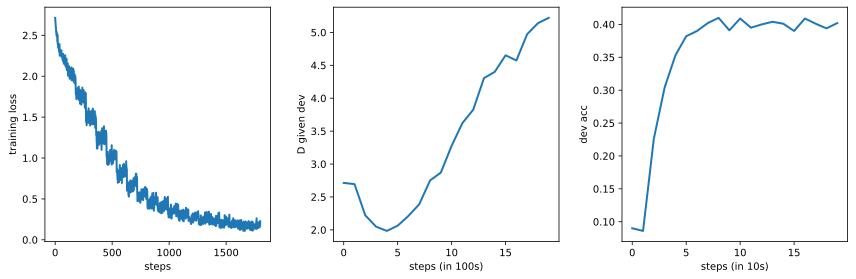

In [42]:
# Now let's train a model on this data.

# First, reset random number generators
seed_all()

# Use GPU acceleration
my_device = torch.device('cuda:0')

# Create the model
model = CategoricalModel(
    support_size=len(brown.categories()),
    hidden_size=32,
    encoder=TextEncoder(
        vocab_size=len(cat_vocab),
        word_embed_dim=100,
        hidden_size=64,
        reduce_mean=True,
        pad_id=cat_vocab.pad_id
    ),
    p_drop=0.1
).to(my_device)

# Construct an Adam optimiser
optimiser = opt.Adam(model.parameters(), lr=5e-3)

print("Model")
print(model)

# Report number of parameters
print(f"Model size: {model.num_parameters():,} parameters")

# Train the model
log = train_neural_model(
    model, optimiser,
    decision_rule=ExactMode(),
    training_data=TextRegressionCorpus(cat_training_x, cat_training_y, cat_vocab),
    dev_data=TextRegressionCorpus(cat_dev_x, cat_dev_y, cat_vocab),
    report_fn=report_classification,
    report_metrics=['accuracy'],
    batch_size=500, num_epochs=20, check_every=100,
    device=my_device
)

# Plot loss and validation checks
fig, axs = plt.subplots(1, 3, sharey=False, figsize=(12, 4))
_ = axs[0].plot(np.arange(len(log['loss'])), log['loss'])
_ = axs[0].set_xlabel('steps')
_ = axs[0].set_ylabel('training loss')
_ = axs[1].plot(np.arange(len(log['D'])), log['D'])
_ = axs[1].set_xlabel('steps (in 100s)')
_ = axs[1].set_ylabel('D given dev')
_ = axs[2].plot(np.arange(len(log['accuracy'])), log['accuracy'])
_ = axs[2].set_xlabel('steps (in 10s)')
_ = axs[2].set_ylabel('dev acc')
_ = fig.tight_layout(h_pad=2, w_pad=2)
plt.show()

In [43]:
# Set up the test dataloader
cat_test_corpus = TextRegressionCorpus(cat_test_x, cat_test_y, cat_vocab)
cat_test_dl = DataLoader(cat_test_corpus, batch_size=3, shuffle=True, collate_fn=cat_test_corpus.pad_to_longest)
batch_x, batch_y = next(iter(cat_test_dl))

# Use the mode to form predictions.
decision_rule = ExactMode()
predictions = decision_rule(model, batch_x.to(my_device))

for x, pred, truth in zip(batch_x, batch_y, predictions):
    print(f"input: {' '.join(cat_vocab.decode(x, strip_pad=True))}")
    print(f"prediction: {brown.categories()[pred]}")
    print(f"truth: {brown.categories()[truth]}")
    print()

input: Have you examined this problem of increasing consumer sophistication from the standpoint of your own company ? ? -EOS-
prediction: hobbies
truth: lore

input: Some have plenty of money -- some have very little money . -EOS-
prediction: lore
truth: lore

input: Thus far the advances made have been almost entirely along functional lines . -EOS-
prediction: belles_lettres
truth: lore



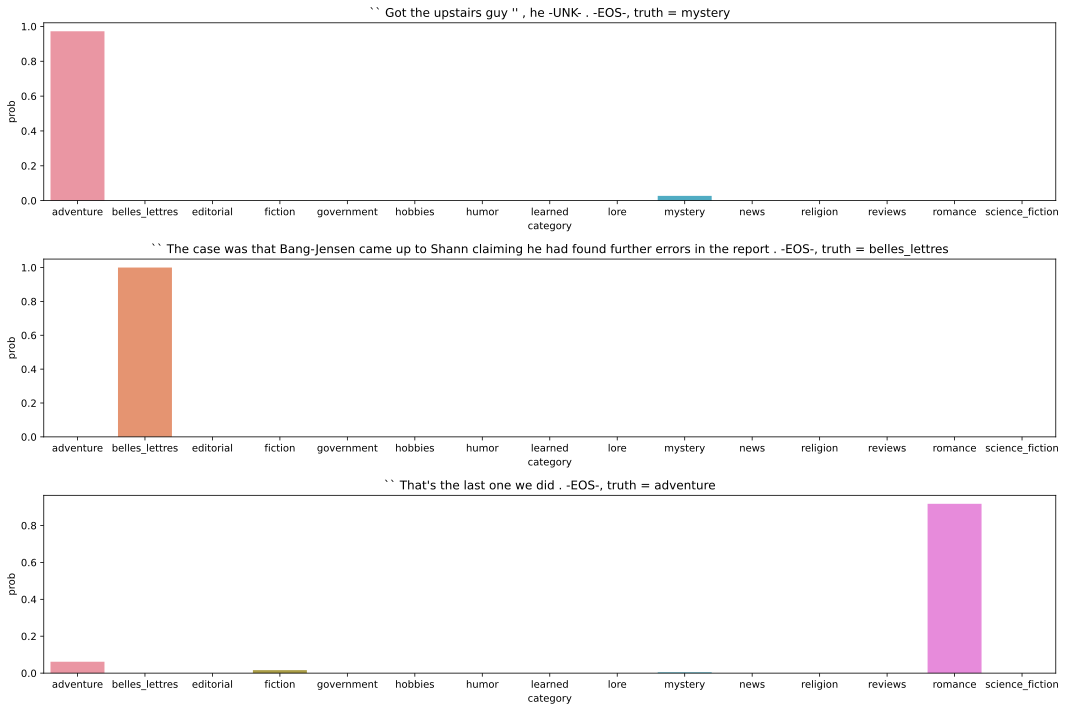

In [44]:
# We can also visualize the predicted Categoricals and use them for sampling or input
# to any arbitrary decision rule.
import seaborn as sns
import pandas as pd

with torch.no_grad():
    batch_x, batch_y = next(iter(cat_test_dl))
    cpds = model(batch_x.to(my_device))

fig, axes = plt.subplots(3, 1, figsize=(15, 10))
for ax, x, y, predicted_probs in zip(axes, batch_x, batch_y, cpds.probs):
    sns.barplot(data=pd.DataFrame({"category": brown.categories(), "prob": predicted_probs.cpu()}),
                x="category", y="prob", ax=ax)
    ax.set_title(f"{' '.join(cat_vocab.decode(x, strip_pad=True))}, truth = {brown.categories()[y]}")

plt.tight_layout()
plt.show()